#### For Assignment 3, I have performed a composite of the North Atlantic Oscillation (NAO) Climate Index with my Northeast U.S. precipitation dataset. Due to the differences in time coordinate between the two arrays (i.e. my dataset shows time coordinates of 12-31-1989T18:00:00), I have grouped both arrays by year in order for the composite to work properly, and organized them on the time scale of 1989-2010. For the NAO index, I have defined the extreme positive and extreme negative values as Positive NAO and Negative NAO phases subsequently, and then performed a composite for precipitation anomalies that occur in the Northeast U.S. during each of these phases.

In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import cartopy.feature as feature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

##### Importing the North Atlantic Oscillation (NAO) Climate Index

In [2]:
path='/home/pdirmeye/classes/clim680_2022/CLIM_INDICES/'
file='nao.data'
index_name='nao'

df=pd.read_table(path+file,skiprows=1,
                 header=None,delim_whitespace=True,
                 index_col=0,parse_dates=True,
                 na_values=['-99.9','-99.90'])
df.drop(df.tail(3).index,inplace=True)

In [3]:
start_date=str(df.index[0])+'-'+str(df.columns[0])+'-01'
end_date=str(df.index[-1])+'-'+str(df.columns[-1])+'-01'
print(start_date)

1948-1-01


In [4]:
dates=pd.date_range(start=start_date,end=end_date,freq='MS')
dates

DatetimeIndex(['1948-01-01', '1948-02-01', '1948-03-01', '1948-04-01',
               '1948-05-01', '1948-06-01', '1948-07-01', '1948-08-01',
               '1948-09-01', '1948-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=876, freq='MS')

In [5]:
clim_index=df.T.unstack().values
clim_index=clim_index.astype('float32')

In [6]:
ds_index=xr.DataArray(clim_index, coords={'time':dates}, dims=['time'])        
ds_index=ds_index.to_dataset(name='nao')
ds_index

<xarray.Dataset>
Dimensions:  (time: 876)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2020-12-01
Data variables:
    nao      (time) float32 nan nan nan nan nan nan ... 0.03 1.11 nan nan nan

##### In order to find a greater correlation between my dataset and the NAO climate index, I decided to confine my analysis to only the cold months of December, January, and February (DJF). I began by putting the seasonal index values into groups by season (DJF, MAM, JJA, SON).

In [7]:
ds_index_g = ds_index.groupby('time.season').groups

##### Next, I created an index that only selects the index values during DJF.

In [8]:
ds_index_D = ds_index_g['DJF']

##### Finally, I put together a DJF NAO index by defining it based on a situation in which the original NAO index contains a time scale of only the cold months (DJF), meaning the time array only includes values during December, January, and February.

In [9]:
ds_index_DJF = ds_index.isel(time=ds_index_D)
ds_index_DJF

<xarray.Dataset>
Dimensions:  (time: 219)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2020-12-01
Data variables:
    nao      (time) float32 nan nan nan nan nan nan ... -0.11 1.02 1.05 0.98 nan

##### Due to the abnormal time coordinate of my dataset (i.e. contains dates such as 12-31-1989T18:00:00), I grouped the climate index data by year so that both it and my dataset will have the same dimension of time

In [10]:
dg_index_DJF = ds_index_DJF.groupby('time.year').mean()

Text(0, 0.5, 'NAO Index')

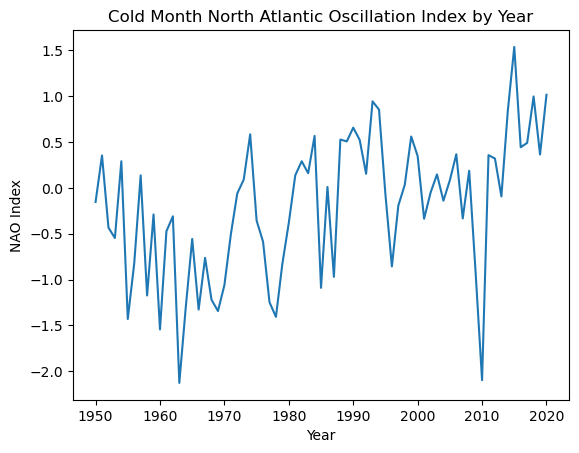

In [11]:
plt.plot(dg_index_DJF['year'], dg_index_DJF['nao'])
plt.title('Cold Month North Atlantic Oscillation Index by Year')
plt.xlabel('Year')
plt.ylabel('NAO Index')

##### Since the NAO only has a positive and negative phase, I defined the nao values greater than or equal to 0.25 as 'positivenao' and the values less than or equal to -0.25 as 'negativenao.' I chose these values instead of zero because these intervals showed a very small p-value area, so I selected values other than zero that would help improve the significance test.

Positive NAO:  6
Neutral NAO:  46
Negative NAO:  19
[array(6), array(19), array(46)]


Text(0, 0.5, 'NAO Index')

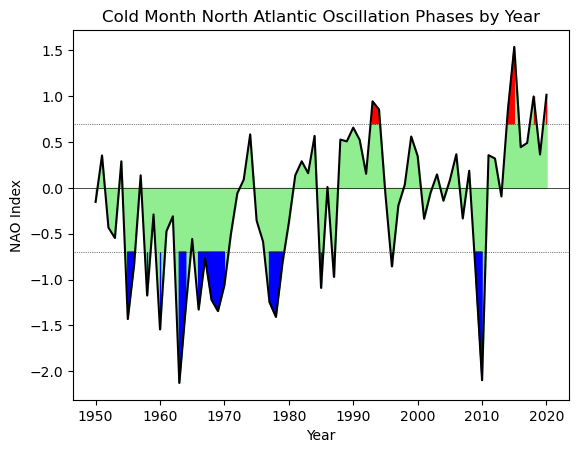

In [12]:
positivenao=dg_index_DJF['nao'].where(dg_index_DJF['nao']>=0.7)
negativenao=dg_index_DJF['nao'].where(dg_index_DJF['nao']<=-0.7)
neutralnao=dg_index_DJF['nao'].where(np.logical_and(dg_index_DJF['nao']>-0.7,
                                              dg_index_DJF['nao']<0.7))

print('Positive NAO: ',positivenao.count(dim='year').values)
print('Neutral NAO: ',neutralnao.count(dim='year').values)
print('Negative NAO: ',negativenao.count(dim='year').values)

counts=[positivenao.count(dim='year').values, 
        negativenao.count(dim='year').values, 
        neutralnao.count(dim='year').values]
print(counts)

plt.plot(dg_index_DJF['year'],dg_index_DJF['nao'],color='k')
plt.fill_between(dg_index_DJF['year'].values,dg_index_DJF['nao'],color='lightgreen')
plt.fill_between(dg_index_DJF['year'].values,positivenao,y2=0.7,color='red')
plt.fill_between(dg_index_DJF['year'].values,negativenao,y2=-0.7,color='blue')
plt.axhline(0,color='black',linewidth=0.5)
plt.axhline(0.7,color='black',linewidth=0.5,linestyle='dotted')
plt.axhline(-0.7,color='black',linewidth=0.5,linestyle='dotted')
plt.title('Cold Month North Atlantic Oscillation Phases by Year')
plt.xlabel('Year')
plt.ylabel('NAO Index')

##### Opening my dataset

In [13]:
file='/home/jstiles4/clim680_dataset/ERA5_Reanalysis_Precip_dataset.grib'
ds=xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:     (time: 252, latitude: 41, longitude: 53)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 1989-12-31T18:00:00 ... 2010-11-30T18:0...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 48.0 47.75 47.5 47.25 ... 38.5 38.25 38.0
  * longitude   (longitude) float64 -80.0 -79.75 -79.5 ... -67.5 -67.25 -67.0
    valid_time  (time) datetime64[ns] ...
Data variables:
    tp          (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-12-02T13:28 GRIB to CDM+CF via cfgrib-0.9.1...

##### Multplying by 1000 so the precipitation values (tp) will show up in units of mm/day

In [14]:
ds = ds*1000

##### Grouping my dataset into groups by season to only account for the DJF months in the same manner as the climate index

In [15]:
dg = ds.groupby('time.season').groups

In [16]:
dg_D = dg['DJF']

In [17]:
ds_DJF = ds.isel(time=dg_D)
ds_DJF

<xarray.Dataset>
Dimensions:     (time: 63, latitude: 41, longitude: 53)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 1989-12-31T18:00:00 ... 2010-02-28T18:0...
    step        timedelta64[ns] 12:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 48.0 47.75 47.5 47.25 ... 38.5 38.25 38.0
  * longitude   (longitude) float64 -80.0 -79.75 -79.5 ... -67.5 -67.25 -67.0
    valid_time  (time) datetime64[ns] 1990-01-01T06:00:00 ... 2010-03-01T06:0...
Data variables:
    tp          (time, latitude, longitude) float32 2.224 2.3 ... 6.441 6.676
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-12-02T13:28 GRIB to CDM+CF via cfgrib-0.9.1...

##### Grouping the ds_DJF dataset by year so the time scale matches with the climate index

In [18]:
dg_DJF = ds_DJF.tp.groupby('time.year').mean()
dg_DJF

<xarray.DataArray 'tp' (year: 22, latitude: 41, longitude: 53)>
array([[[2.2239685 , 2.3002625 , 2.401352  , ..., 3.2520294 ,
         3.3245087 , 3.487587  ],
        [2.1772385 , 2.2802353 , 2.3813248 , ..., 3.3597946 ,
         3.3979416 , 3.293991  ],
        [2.2716522 , 2.3679733 , 2.4347305 , ..., 3.5161972 ,
         3.5161972 , 3.411293  ],
        ...,
        [4.511833  , 3.9844513 , 3.4132004 , ..., 5.3243637 ,
         5.461693  , 5.534172  ],
        [3.9958954 , 3.7212372 , 3.4475327 , ..., 5.701065  ,
         5.800247  , 5.917549  ],
        [3.70121   , 3.7021637 , 3.6649704 , ..., 6.017685  ,
         6.1130524 , 6.3905716 ]],

       [[1.5211105 , 1.592954  , 1.6915003 , ..., 1.7433167 ,
         1.7328262 , 1.7547607 ],
        [1.4810562 , 1.5796026 , 1.6781489 , ..., 1.8021265 ,
         1.7903646 , 1.7658869 ],
        [1.5242895 , 1.610438  , 1.6638438 , ..., 1.9140244 ,
         1.9156138 , 1.8917719 ],
...
        [3.1369526 , 2.8063457 , 2.4592083 , ..., 6.4376197 ,
         6.4487457 , 6.389618  ],
        [3.1172435 , 2.7777355 , 2.5110245 , ..., 6.9262185 ,
         6.84611   , 6.785711  ],
        [2.9392242 , 2.5997162 , 2.5119781 , ..., 7.515589  ,
         7.3979697 , 7.3928833 ]],

       [[0.8096695 , 0.8382797 , 0.8621216 , ..., 2.19059   ,
         2.1800995 , 2.1915436 ],
        [0.80013275, 0.7829666 , 0.8058548 , ..., 2.1858215 ,
         2.2439957 , 2.4032593 ],
        [0.77724457, 0.7677078 , 0.7839203 , ..., 2.2420883 ,
         2.3107529 , 2.4709702 ],
        ...,
        [3.6334991 , 3.2262802 , 3.0088425 , ..., 6.7014694 ,
         6.7014694 , 6.934166  ],
        [3.209114  , 2.8591156 , 2.7742386 , ..., 7.1525574 ,
         7.2956085 , 7.5178146 ],
        [2.8800964 , 2.653122  , 2.7751923 , ..., 7.4539185 ,
         7.6436996 , 7.9011917 ]]], dtype=float32)
Coordinates:
    number     int64 0
    step       timedelta64[ns] 12:00:00
    surface    float64 0.0
  * latitude   (latitude) float64 48.0 47.75 47.5 47.25 ... 38.5 38.25 38.0
  * longitude  (longitude) float64 -80.0 -79.75 -79.5 ... -67.5 -67.25 -67.0
  * year       (year) int64 1989 1990 1991 1992 1993 ... 2007 2008 2009 2010

##### Here, I calculated the mean values for daily precipitation by year for the entire Northeast U.S. (da_climo) and subtracted these mean values from all of the values for daily precipitation by year to get the daily precipiation anomaly values (da_anoms). 

In [19]:
da_climo = dg_DJF.mean()
da_anoms = dg_DJF-da_climo
da_anoms

<xarray.DataArray 'tp' (year: 22, latitude: 41, longitude: 53)>
array([[[-0.90167403, -0.8253801 , -0.7242906 , ...,  0.12638688,
          0.19886613,  0.36194444],
        [-0.9484041 , -0.84540725, -0.74431777, ...,  0.23415208,
          0.27229905,  0.16834855],
        [-0.8539903 , -0.7576692 , -0.690912  , ...,  0.39055467,
          0.39055467,  0.2856505 ],
        ...,
        [ 1.3861907 ,  0.85880876,  0.28755784, ...,  2.1987212 ,
          2.3360503 ,  2.4085295 ],
        [ 0.87025285,  0.59559464,  0.32189012, ...,  2.5754225 ,
          2.6746047 ,  2.7919066 ],
        [ 0.5755675 ,  0.57652116,  0.53932786, ...,  2.8920424 ,
          2.9874098 ,  3.264929  ]],

       [[-1.604532  , -1.5326885 , -1.4341422 , ..., -1.3823259 ,
         -1.3928163 , -1.3708818 ],
        [-1.6445863 , -1.5460399 , -1.4474937 , ..., -1.323516  ,
         -1.3352779 , -1.3597556 ],
        [-1.601353  , -1.5152045 , -1.4617988 , ..., -1.2116182 ,
         -1.2100288 , -1.2338706 ],
...
        [ 0.0113101 , -0.31929684, -0.6664343 , ...,  3.3119771 ,
          3.3231032 ,  3.2639754 ],
        [-0.00839901, -0.34790707, -0.61461806, ...,  3.800576  ,
          3.7204673 ,  3.6600683 ],
        [-0.1864183 , -0.52592635, -0.6136644 , ...,  4.389947  ,
          4.2723274 ,  4.2672405 ]],

       [[-2.315973  , -2.2873628 , -2.263521  , ..., -0.93505263,
         -0.94554305, -0.93409896],
        [-2.3255098 , -2.342676  , -2.3197877 , ..., -0.939821  ,
         -0.8816469 , -0.72238326],
        [-2.348398  , -2.3579347 , -2.3417222 , ..., -0.8835542 ,
         -0.81488967, -0.6546724 ],
        ...,
        [ 0.5078566 ,  0.10063767, -0.11680007, ...,  3.575827  ,
          3.575827  ,  3.8085234 ],
        [ 0.08347154, -0.26652694, -0.35140395, ...,  4.0269146 ,
          4.1699657 ,  4.392172  ],
        [-0.2455461 , -0.4725206 , -0.35045028, ...,  4.3282757 ,
          4.518057  ,  4.775549  ]]], dtype=float32)
Coordinates:
    number     int64 0
    step       timedelta64[ns] 12:00:00
    surface    float64 0.0
  * latitude   (latitude) float64 48.0 47.75 47.5 47.25 ... 38.5 38.25 38.0
  * longitude  (longitude) float64 -80.0 -79.75 -79.5 ... -67.5 -67.25 -67.0
  * year       (year) int64 1989 1990 1991 1992 1993 ... 2007 2008 2009 2010

##### Each of the NAO phases needed to be sliced to have the same interval of years (1990-2010) as my dataset

In [20]:
positivenao_g = positivenao.sel(year=slice(dg_DJF['year'][0],dg_DJF['year'][-1]))
neutralnao_g = neutralnao.sel(year=slice(dg_DJF['year'][0],dg_DJF['year'][-1]))
negativenao_g = negativenao.sel(year=slice(dg_DJF['year'][0],dg_DJF['year'][-1]))

##### Here, I matched the anomalies by year with the respective years in which the Positive NAO, Neutral NAO, or Negative NAO occurred

In [21]:
positivenao_tp = da_anoms.sel(year=positivenao_g.dropna(dim='year')['year']).mean(dim='year')
neutralnao_tp = da_anoms.sel(year=neutralnao_g.dropna(dim='year')['year']).mean(dim='year')
negativenao_tp = da_anoms.sel(year=negativenao_g.dropna(dim='year')['year']).mean(dim='year')

comp_precip = [positivenao_tp, neutralnao_tp, negativenao_tp]
comp_precip

[<xarray.DataArray 'tp' (latitude: 41, longitude: 53)>
 array([[-1.9311655 , -1.9190856 , -1.891747  , ..., -0.3905046 ,
         -0.33058214, -0.26907003],
        [-1.9105024 , -1.8993764 , -1.8725145 , ..., -0.32581365,
         -0.27352047, -0.23187685],
        [-1.8679051 , -1.8556662 , -1.8276918 , ..., -0.25158608,
         -0.21169066, -0.16925216],
        ...,
        [ 2.8654985 ,  2.550786  ,  2.1578722 , ...,  3.8943539 ,
          4.132137  ,  4.4082255 ],
        [ 2.8095496 ,  2.3834162 ,  2.0629816 , ...,  4.3109508 ,
          4.503593  ,  4.7817483 ],
        [ 2.5658858 ,  2.0140262 ,  1.9034    , ...,  4.7941456 ,
          5.0753207 ,  5.3158054 ]], dtype=float32)
 Coordinates:
     number     int64 0
     step       timedelta64[ns] 12:00:00
     surface    float64 0.0
   * latitude   (latitude) float64 48.0 47.75 47.5 47.25 ... 38.5 38.25 38.0
   * longitude  (longitude) float64 -80.0 -79.75 -79.5 ... -67.5 -67.25 -67.0,
 <xarray.DataArray 'tp' (latitude: 41, lo

##### These are the plots for the average anomalies that occured during the extreme Positive NAO years or extreme Negative NAO year, as well as the Neutral NAO years of less extreme NAO values. For these plots and most of the remaining plots, a colorbar scale was used that is larger than all of the values in the anomalies. This had to be done because there was no other suitable method of representing all anomalies in the plots, because the positive anomalies go much further from zero than the negative anomalies. Otherwise, the color scale would not have centered around zero and the colors would have incorrectly represented the data.

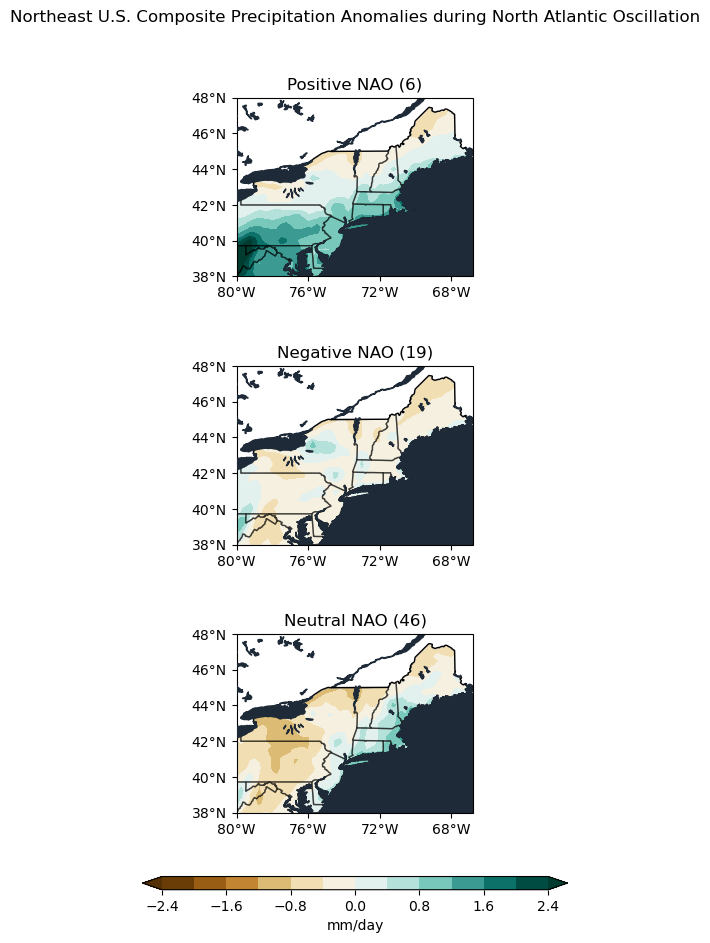

In [32]:
labels=['Positive NAO', 'Negative NAO', 'Neutral NAO']
clevs = np.arange(-2.4,2.8,0.4)

fig, axs = plt.subplots(nrows=3,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-74)},
                        figsize=(8.5,11))

axs = axs.flatten()

for i,tp in enumerate(comp_precip):

        data = comp_precip[i]

        data,lons = add_cyclic_point(data,coord=comp_precip[i]['longitude'])

        cs=axs[i].contourf(lons,comp_precip[i]['latitude'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

        axs[i].set_xticks([-80,-76,-72,-68], crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        axs[i].set_yticks([38,40,42,44,46,48], crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        axs[i].set_title(labels[i]+' ('+str(counts[i])+')')

        axs[i].coastlines()
        axs[i].add_feature(feature.OCEAN, zorder=2, color='#1F2A38')
        axs[i].add_feature(feature.BORDERS, zorder=2, color='k')
        axs[i].add_feature(feature.LAKES, zorder=3, color='#1F2A38')
        axs[i].add_feature(feature.BORDERS.with_scale('10m'),
               linestyle='-', alpha=.5)
        axs[i].add_feature(feature.STATES.with_scale('10m'),
               linestyle='-', alpha=.5)
        
        fname='/home/jstiles4/gadm41_CAN_1.shp'
        shape_feature = ShapelyFeature(Reader(fname).geometries(),
                               ccrs.PlateCarree(), edgecolor='black', color='white')
        
        axs[i].add_feature(shape_feature)
        
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])

cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='mm/day')

plt.suptitle('Northeast U.S. Composite Precipitation Anomalies during North Atlantic Oscillation') ;

##### This is where I began the significance test for the composite, and I assigned two differences to the precipitation differences (diff_precip) array, those being Positive NAO Precipitation - Neutral NAO Precipitation and Negative NAO Precipitation - Neutral NAO Precipitation.

In [23]:
diff_precip=[positivenao_tp-neutralnao_tp, negativenao_tp-neutralnao_tp]

In [24]:
p = 0.05

##### For the t-test, I matched the anomaly values with the respective positive, neutral, and negative NAO years

In [25]:
from scipy.stats import ttest_ind

positivenao_precip_vals = da_anoms.sel(year=positivenao_g.dropna(dim='year')['year'])
neutralnao_precip_vals = da_anoms.sel(year=neutralnao_g.dropna(dim='year')['year'])
negativenao_precip_vals = da_anoms.sel(year=negativenao_g.dropna(dim='year')['year'])

##### Here, I performed the t-test between the positive nao precipitation values and the neutral nao precipitation values

In [26]:
tstat,pval = ttest_ind(positivenao_precip_vals, 
                neutralnao_precip_vals, 
                equal_var = False)

##### This is the contour plot for the areas where the pvalue < p

Text(0.5, 1.0, 'Significance Test Map')

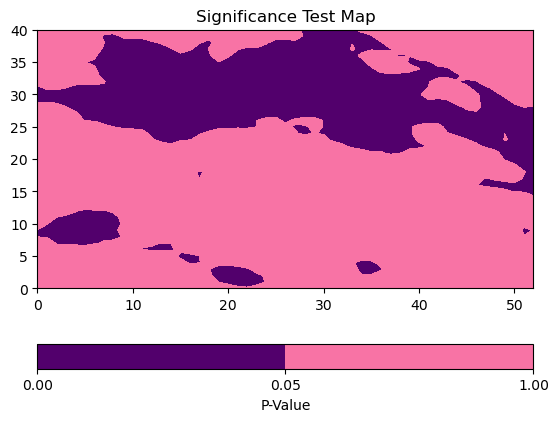

In [27]:
plt.contourf(pval,[0,0.05,1],cmap='RdPu_r') 
plt.colorbar(orientation='horizontal', label='P-Value') ;
plt.title('Significance Test Map')

In [28]:
mask_diff = diff_precip[0].where(pval <= p)
mask_diff

<xarray.DataArray 'tp' (latitude: 41, longitude: 53)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan, 2.2223978,       nan, ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
    number     int64 0
    step       timedelta64[ns] 12:00:00
    surface    float64 0.0
  * latitude   (latitude) float64 48.0 47.75 47.5 47.25 ... 38.5 38.25 38.0
  * longitude  (longitude) float64 -80.0 -79.75 -79.5 ... -67.5 -67.25 -67.0

##### These plots show the previously mentioned precipitation differences in diff_precip

Text(0.5, 0.98, 'Northeast U.S. Composite Precipitation Differences during North Atlantic Oscillation')

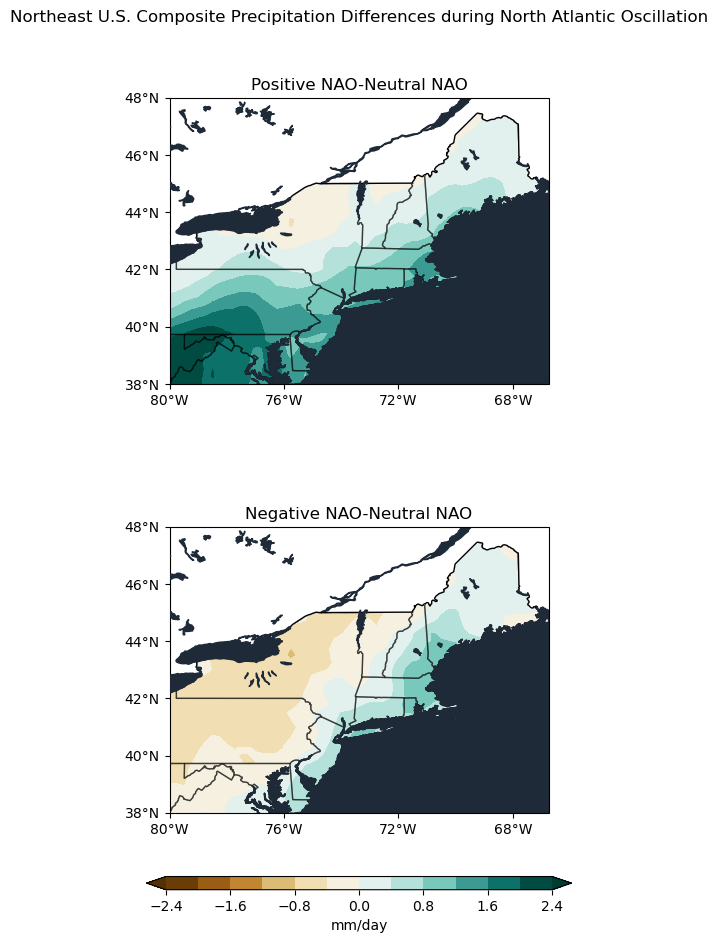

In [33]:
labels=['Positive NAO-Neutral NAO','Negative NAO-Neutral NAO']
clevs=np.arange(-2.4,2.8,0.4)

fig, axs = plt.subplots(nrows=2,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,11))

axs = axs.flatten()

for i,enso in enumerate(diff_precip):

        data = diff_precip[i]

        data,lons = add_cyclic_point(data,coord=diff_precip[i]['longitude'])

        cs = axs[i].contourf(lons,diff_precip[i]['latitude'],data,clevs,
                          transform=ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

        axs[i].set_xticks([-80,-76,-72,-68], crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        axs[i].set_yticks([38,40,42,44,46,48], crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        axs[i].set_title(labels[i])
        
        axs[i].coastlines()
        axs[i].add_feature(feature.OCEAN, zorder=2, color='#1F2A38')
        axs[i].add_feature(feature.BORDERS, zorder=2, color='k')
        axs[i].add_feature(feature.LAKES, zorder=3, color='#1F2A38')
        axs[i].add_feature(feature.BORDERS.with_scale('10m'),
               linestyle='-', alpha=.5)
        axs[i].add_feature(feature.STATES.with_scale('10m'),
               linestyle='-', alpha=.5)
        
        fname='/home/jstiles4/gadm41_CAN_1.shp'
        shape_feature = ShapelyFeature(Reader(fname).geometries(),
                               ccrs.PlateCarree(), edgecolor='black', color='white')
        
        axs[i].add_feature(shape_feature)
        
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])

cbar = fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='mm/day')

plt.suptitle('Northeast U.S. Composite Precipitation Differences during North Atlantic Oscillation')

##### Finally, I created a plot to show both the composite differences between Positive NAO-Negative NAO and the areas where the composite is significant. Based on this plot, it is mainly the southern half of the Northeast U.S. that shows significance with the extreme NAO events, as the states of Pennsylvania, New Jersey, Maryland, and Northern Virginia show the most significance.

Text(0.5, 0.98, 'Northeast U.S. Composite Precipitation Differences Positive NAO-Neutral NAO')

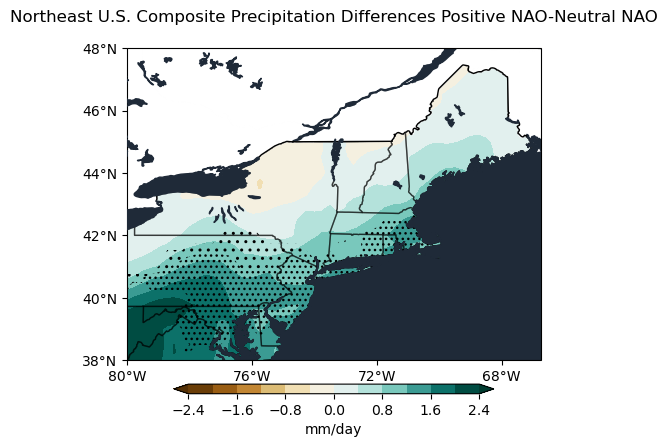

In [34]:
labels=['Positive NAO vs. Negative NAO']
clevs=np.arange(-2.4,2.8,0.4)
hatch_levs=[0]

fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-74)})


data=diff_precip[0]

data,lons=add_cyclic_point(data,coord=diff_precip[0]['longitude'])
mask_data,lons=add_cyclic_point(mask_diff,coord=diff_precip[0]['longitude'])

cs=axs.contourf(lons,diff_precip[0]['latitude'],data,clevs,
                transform = ccrs.PlateCarree(),
                cmap='BrBG',extend='both')

ss=axs.contourf(lons,diff_precip[0]['latitude'],mask_data,[0,1],
                transform = ccrs.PlateCarree(),colors=['None'],
                hatches=['...','..'],extend='both',alpha=0.0)

axs.set_xticks([-80,-76,-72,-68], crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
axs.xaxis.set_major_formatter(lon_formatter)

axs.set_yticks([38,40,42,44,46,48], crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
axs.yaxis.set_major_formatter(lat_formatter)

axs.coastlines()
axs.add_feature(feature.OCEAN, zorder=2, color='#1F2A38')
axs.add_feature(feature.BORDERS, zorder=2, color='k')
axs.add_feature(feature.LAKES, zorder=3, color='#1F2A38')
axs.add_feature(feature.BORDERS.with_scale('10m'),
               linestyle='-', alpha=.5)
axs.add_feature(feature.STATES.with_scale('10m'),
               linestyle='-', alpha=.5)
        
fname='/home/jstiles4/gadm41_CAN_1.shp'
shape_feature = ShapelyFeature(Reader(fname).geometries(),
                               ccrs.PlateCarree(), edgecolor='black', color='white')
        
axs.add_feature(shape_feature)
        
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.02])

cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='mm/day')

plt.suptitle('Northeast U.S. Composite Precipitation Differences Positive NAO-Neutral NAO')